In [6]:
import geopandas as gpd
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight
import os

In [20]:
city = 'Rotterdam'
felyxotp = pd.read_pickle('OTPFused/felyxfused' + city)
PCs = gpd.read_file(os.path.join('..', 'PublicGeoJsons', city + 'PC4.geojson'))
pcdata = pd.read_pickle('../PostcodeInfo/PCData')
pcdata.index.names = ['pc4']
pcdata = pcdata.reset_index()

In [21]:
felyxotp = felyxotp.dropna()

In [22]:
felyxotp = felyxotp.replace({-3: np.nan})
felyxotp.head()

,tripid,carId,fuelLevel,time,lat,lon,geometry,prev_time,timedelta,prev_location,distancemoved,prev_fl,pt_dur,pt_dist,walk_dur,walk_dist,bike_dur,bike_dist,car_dur,car_dist
10001,10001,1473,47,2023-01-20 11:31:12,51.935921,4.485001,POINT (4.48500 51.93592),2023-01-20 11:18:24,0 days 00:12:48,POINT (4.47549 51.93496),0.009559,48.0,622.0,795.050000,622.0,795.050,204.0,833.610,166.0,831.277
10056,10056,1478,36,2023-01-04 18:14:24,51.934622,4.467424,POINT (4.46742 51.93462),2023-01-04 18:08:00,0 days 00:06:24,POINT (4.48561 51.93210),0.018360,38.0,1135.0,1440.950000,1135.0,1440.950,332.0,1440.950,330.0,1445.767
10083,10083,1478,28,2023-01-14 00:10:40,51.928554,4.466719,POINT (4.46672 51.92855),2023-01-13 23:53:36,0 days 00:17:04,POINT (4.45910 51.90422),0.025499,33.0,1601.0,4831.200630,2584.0,3230.277,770.0,3321.548,681.0,3365.653
10156,10156,1482,29,2023-01-17 10:31:28,51.893811,4.465532,POINT (4.46553 51.89381),2023-01-17 10:20:48,0 days 00:10:40,POINT (4.47680 51.90795),0.018080,31.0,1963.0,4820.393964,1808.0,2279.646,720.0,2201.092,751.0,4615.957
10204,10204,1482,40,2023-01-28 16:44:48,51.907843,4.440811,POINT (4.44081 51.90784),2023-01-28 16:29:52,0 days 00:14:56,POINT (4.47184 51.92149),0.033897,44.0,1537.0,5479.078825,2388.0,3032.683,703.0,3094.438,749.0,3748.887


In [26]:
print(len(felyxotp.carId.unique()))
len(felyxotp)


641


1003

In [12]:
# felyxotp[felyxotp.walk_dist.isna()]

In [13]:
# felyxotp[felyxotp.isna()]

In [27]:
felyxotp = felyxotp.dropna()

In [28]:
from datetime import timedelta
felyxotp = felyxotp[felyxotp.timedelta < timedelta(minutes = 100)]
felyxotp = felyxotp[felyxotp.timedelta > timedelta(minutes = 2)]
mean = felyxotp['distancemoved'].mean()
std = felyxotp['distancemoved'].std()
# felyxotp = felyxotp[np.abs(felyxotp['distancemoved'] - mean) <= 2.5 * std]
felyxotp = felyxotp[felyxotp['walk_dist']  >= 500]

felyxotp.head()

,tripid,carId,fuelLevel,time,lat,lon,geometry,prev_time,timedelta,prev_location,distancemoved,prev_fl,pt_dur,pt_dist,walk_dur,walk_dist,bike_dur,bike_dist,car_dur,car_dist
10001,10001,1473,47,2023-01-20 11:31:12,51.935921,4.485001,POINT (4.48500 51.93592),2023-01-20 11:18:24,0 days 00:12:48,POINT (4.47549 51.93496),0.009559,48.0,622.0,795.050000,622.0,795.050,204.0,833.610,166.0,831.277
10056,10056,1478,36,2023-01-04 18:14:24,51.934622,4.467424,POINT (4.46742 51.93462),2023-01-04 18:08:00,0 days 00:06:24,POINT (4.48561 51.93210),0.018360,38.0,1135.0,1440.950000,1135.0,1440.950,332.0,1440.950,330.0,1445.767
10083,10083,1478,28,2023-01-14 00:10:40,51.928554,4.466719,POINT (4.46672 51.92855),2023-01-13 23:53:36,0 days 00:17:04,POINT (4.45910 51.90422),0.025499,33.0,1601.0,4831.200630,2584.0,3230.277,770.0,3321.548,681.0,3365.653
10156,10156,1482,29,2023-01-17 10:31:28,51.893811,4.465532,POINT (4.46553 51.89381),2023-01-17 10:20:48,0 days 00:10:40,POINT (4.47680 51.90795),0.018080,31.0,1963.0,4820.393964,1808.0,2279.646,720.0,2201.092,751.0,4615.957
10204,10204,1482,40,2023-01-28 16:44:48,51.907843,4.440811,POINT (4.44081 51.90784),2023-01-28 16:29:52,0 days 00:14:56,POINT (4.47184 51.92149),0.033897,44.0,1537.0,5479.078825,2388.0,3032.683,703.0,3094.438,749.0,3748.887


In [29]:
felyxotp['seconds'] = felyxotp.time.dt.second + 60*(felyxotp.time.dt.hour)

In [30]:
felyxotp['hour'] = felyxotp.time.dt.hour
felyxotp['weekdag'] = felyxotp.time.dt.dayofweek
seconds_in_day = 24*60*60
felyxotp['sin_time'] = np.sin(2*np.pi*felyxotp.seconds/seconds_in_day)
felyxotp['cos_time'] = np.cos(2*np.pi*felyxotp.seconds/seconds_in_day)
felyxotp = felyxotp.drop([ 'seconds'], axis = 1)

In [31]:
len(felyxotp)

838

In [37]:
if city == 'Amsterdam':
    felyxotp = felyxotp.join(
        gpd.GeoDataFrame(
            felyxotp[['prev_location']], geometry=felyxotp[['prev_location']].prev_location,
            crs='EPSG:4326'
        ).drop('prev_location', axis=1).sjoin(PCs.rename(columns={'Postcode4': 'vertpc'})).vertpc
    )
    felyxotp = felyxotp.join(
        gpd.GeoDataFrame(
            felyxotp, geometry=felyxotp.geometry,
            crs='EPSG:4326'
        ).sjoin(PCs.rename(columns={'Postcode4': 'aankpc'})).aankpc
    )

In [33]:
if city == 'Rotterdam':
    felyxotp = felyxotp.join(
        gpd.GeoDataFrame(
            felyxotp[['prev_location']], geometry=felyxotp[['prev_location']].prev_location,
            crs='EPSG:4326'
        ).drop('prev_location', axis=1).sjoin(PCs.rename(columns={'pc4_code': 'vertpc'})).vertpc
    )
    felyxotp = felyxotp.join(
        gpd.GeoDataFrame(
            felyxotp, geometry=felyxotp.geometry,
            crs='EPSG:4326'
        ).sjoin(PCs.rename(columns={'pc4_code': 'aankpc'})).aankpc
    )

In [34]:
felyxotp

,tripid,carId,fuelLevel,time,lat,lon,geometry,prev_time,timedelta,prev_location,...,bike_dur,bike_dist,car_dur,car_dist,hour,weekdag,sin_time,cos_time,vertpc,aankpc
10001,10001,1473,47,2023-01-20 11:31:12,51.935921,4.485001,POINT (4.48500 51.93592),2023-01-20 11:18:24,0 days 00:12:48,POINT (4.47549 51.93496),...,204.0,833.610,166.0,831.277,11,4,0.048850,0.998806,3035,3036
10056,10056,1478,36,2023-01-04 18:14:24,51.934622,4.467424,POINT (4.46742 51.93462),2023-01-04 18:08:00,0 days 00:06:24,POINT (4.48561 51.93210),...,332.0,1440.950,330.0,1445.767,18,2,0.080199,0.996779,3035,3038
10083,10083,1478,28,2023-01-14 00:10:40,51.928554,4.466719,POINT (4.46672 51.92855),2023-01-13 23:53:36,0 days 00:17:04,POINT (4.45910 51.90422),...,770.0,3321.548,681.0,3365.653,0,5,0.002909,0.999996,3024,3033
10156,10156,1482,29,2023-01-17 10:31:28,51.893811,4.465532,POINT (4.46553 51.89381),2023-01-17 10:20:48,0 days 00:10:40,POINT (4.47680 51.90795),...,720.0,2201.092,751.0,4615.957,10,1,0.045654,0.998957,3016,3082
10204,10204,1482,40,2023-01-28 16:44:48,51.907843,4.440811,POINT (4.44081 51.90784),2023-01-28 16:29:52,0 days 00:14:56,POINT (4.47184 51.92149),...,703.0,3094.438,749.0,3748.887,16,5,0.073238,0.997314,3014,3029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9401,9401,1220,88,2023-01-28 10:31:28,51.929170,4.458970,POINT (4.45897 51.92917),2023-01-28 10:25:04,0 days 00:06:24,POINT (4.46054 51.92002),...,304.0,1310.355,332.0,1507.001,10,5,0.045654,0.998957,3021,3039
9422,9422,1220,22,2023-01-31 19:35:28,51.921473,4.505748,POINT (4.50575 51.92147),2023-01-31 19:31:12,0 days 00:04:16,POINT (4.51734 51.91720),...,240.0,1001.393,304.0,1258.052,19,1,0.084837,0.996395,3063,3063
9487,9487,1233,31,2023-01-19 12:18:08,51.927822,4.509963,POINT (4.50996 51.92782),2023-01-19 12:11:44,0 days 00:06:24,POINT (4.52381 51.91974),...,382.0,1601.300,433.0,1691.192,12,3,0.052917,0.998599,3062,3061
9820,9820,1261,87,2023-01-22 15:06:40,51.942127,4.477140,POINT (4.47714 51.94213),2023-01-22 14:58:08,0 days 00:08:32,POINT (4.47238 51.93474),...,334.0,1398.461,369.0,1481.122,15,6,0.068306,0.997664,3037,3037


In [38]:
# felyxotp[['hour','vertpc','aankpc']] = felyxotp[['hour','vertpc','aankpc']].astype(str)
felyxotp[['vertpc','aankpc']] = felyxotp[['vertpc','aankpc']].astype(str)

In [68]:
import holidays
felyxotp['feestdag'] = felyxotp['prev_time'].apply(lambda x: x in(holidays.NL())).astype(int)

In [70]:
len(felyxotp)

838

In [71]:
felyxotp.weekdag = felyxotp.weekdag.replace({0:'Maandag', 1:'Dinsdag', 2:'Woensdag', 3:'Donderdag', 4:'Vrijdag', 5:'Zaterdag', 6:'Zondag'})

In [72]:
felyxotp['oprijbewijsau'] = [1] * len(felyxotp)

In [73]:
felyxotp = felyxotp.merge(pcdata.add_prefix('aank '), left_on = 'aankpc', right_on = 'aank pc4')
felyxotp = felyxotp.merge(pcdata.add_prefix('vert '), left_on = 'vertpc', right_on = 'vert pc4')
felyxotp = felyxotp.drop(['aank pc4', 'vert pc4'], axis = 1)

In [74]:
felyxotp.head()

,tripid,carId,fuelLevel,time,lat,lon,geometry,prev_time,timedelta,prev_location,...,vert 2005 tot 2015,vert 2015 en later,vert Meergezins,vert Koopwoning,vert Huurwoning,vert Huurcoporatie,vert Niet bewoond,vert WOZ-waarde\nwoning,"vert Personen met WW, Bijstand en/of AO uitkering\nBeneden AOW-leeftijd",vert density
0,10001,1473,47,2023-01-20 11:31:12,51.935921,4.485001,POINT (4.48500 51.93592),2023-01-20 11:18:24,0 days 00:12:48,POINT (4.47549 51.93496),...,0.01007,0.007904,0.492099,0.000582,0.000831,0.312614,0.019248,0.000187,0.144554,0.691776
1,67105,8345,28,2023-01-03 11:54:40,51.941912,4.480829,POINT (4.48083 51.94191),2023-01-03 11:44:00,0 days 00:10:40,POINT (4.48380 51.93122),...,0.01007,0.007904,0.492099,0.000582,0.000831,0.312614,0.019248,0.000187,0.144554,0.691776
2,10056,1478,36,2023-01-04 18:14:24,51.934622,4.467424,POINT (4.46742 51.93462),2023-01-04 18:08:00,0 days 00:06:24,POINT (4.48561 51.93210),...,0.01007,0.007904,0.492099,0.000582,0.000831,0.312614,0.019248,0.000187,0.144554,0.691776
3,2661,754,49,2023-01-16 19:44:00,51.929100,4.467794,POINT (4.46779 51.92910),2023-01-16 19:31:12,0 days 00:12:48,POINT (4.48650 51.93458),...,0.01007,0.007904,0.492099,0.000582,0.000831,0.312614,0.019248,0.000187,0.144554,0.691776
4,37663,3516,18,2023-01-17 17:57:20,51.928467,4.469557,POINT (4.46956 51.92847),2023-01-17 17:48:48,0 days 00:08:32,POINT (4.47931 51.93376),...,0.01007,0.007904,0.492099,0.000582,0.000831,0.312614,0.019248,0.000187,0.144554,0.691776


In [79]:
felyxotp.to_pickle('FelyxModellingData/felyxotp' + city)

In [80]:
for col in felyxotp.columns:
    print(col)

tripid
carId
fuelLevel
time
lat
lon
geometry
prev_time
timedelta
prev_location
distancemoved
prev_fl
pt_dur
pt_dist
walk_dur
walk_dist
bike_dur
bike_dist
car_dur
car_dist
hour
weekdag
sin_time
cos_time
vertpc
aankpc
feestdag
oprijbewijsau
aank Totaal
aank Man
aank Vrouw
aank tot 15 jaar
aank 15 tot 25 jaar
aank 25 tot 45 jaar
aank 45 tot 65 jaar
aank 65 jaar en ouder
aank Geboren in Nederland met een Nederlandse herkomst
aank Geboren in Nederland met een Europese herkomst (excl. Nederland)
aank Geboren in Nederland met herkomst buiten Europa
aank Geboren buiten Nederland met een Europese herkomst (excl. Nederland)
aank Geboren buiten Nederland met een herkomst buiten Europa
aank Totaal.1
aank Eenpersoons
aank Meerpersoons 
zonder kinderen
aank Eenouder
aank Tweeouder
aank Huishoudgrootte
aank Totaal.2
aank voor 1945
aank 1945 tot 1965
aank 1965 tot 1975
aank 1975 tot 1985
aank 1985 tot 1995
aank 1995 tot 2005
aank 2005 tot 2015
aank 2015 en later
aank Meergezins
aank Koopwoning
aank Hu

In [81]:
test_data = pd.read_pickle('FelyxModellingData/felyxotp' + city)

In [82]:
train_data = pd.read_pickle('../Odin/OdinModellingData/Odin2019All').sample(10000)

In [83]:
# choice_dict = pd.read_json('../Odin/OdinData/odin-col-dict.json')
# train_data = train_data.replace({"khvm": dict(choice_dict['khvm'])})

In [84]:
X_train = train_data.drop('khvm', axis=1)
y_train = train_data['khvm']

In [85]:
cols = list(set(X_train.columns).intersection(set(test_data.columns)))

In [86]:
X_train = X_train[cols]
X_test = test_data[cols]

In [87]:
X_test

,aank Geboren buiten Nederland met een herkomst buiten Europa,vert 15 tot 25 jaar,bike_dist,vert 65 jaar en ouder,aank Huurwoning,aank Huurcoporatie,vert 25 tot 45 jaar,vert Huurwoning,weekdag,aank Geboren in Nederland met een Nederlandse herkomst,...,vert Man,vert Huishoudgrootte,vert Totaal.1,aank 25 tot 45 jaar,vert Eenpersoons,aank 1975 tot 1985,aank 1945 tot 1965,vert WOZ-waarde\nwoning,aank Totaal.2,aank 65 jaar en ouder
0,0.002385,0.144226,833.610,0.118862,0.000727,0.300139,0.350538,0.000831,Vrijdag,0.000316,...,0.373636,0.000192,0.537252,0.333358,0.315369,0.041166,0.014561,0.000187,0.165491,0.097964
1,0.002385,0.144226,1472.328,0.118862,0.000727,0.300139,0.350538,0.000831,Dinsdag,0.000316,...,0.373636,0.000192,0.537252,0.333358,0.315369,0.041166,0.014561,0.000187,0.165491,0.097964
2,0.001555,0.144226,1440.950,0.118862,0.000622,0.122368,0.350538,0.000831,Woensdag,0.000556,...,0.373636,0.000192,0.537252,0.536571,0.315369,0.000157,0.054037,0.000187,0.210977,0.067679
3,0.003931,0.144226,1758.682,0.118862,0.001048,0.234675,0.350538,0.000831,Maandag,0.000773,...,0.373636,0.000192,0.537252,0.404806,0.315369,0.023250,0.034523,0.000187,0.191085,0.106075
4,0.003931,0.144226,1249.075,0.118862,0.001048,0.234675,0.350538,0.000831,Dinsdag,0.000773,...,0.373636,0.000192,0.537252,0.404806,0.315369,0.023250,0.034523,0.000187,0.191085,0.106075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,0.000861,0.117315,1876.658,0.122386,0.000344,0.102849,0.290232,0.000403,Woensdag,0.000141,...,0.380799,0.000100,0.433052,0.397058,0.202268,0.025921,0.198014,0.000076,0.191294,0.088667
834,0.001353,0.117315,602.631,0.122386,0.000412,0.333705,0.290232,0.000403,Woensdag,0.000223,...,0.380799,0.000100,0.433052,0.284826,0.202268,0.011093,0.350369,0.000076,0.178987,0.169299
835,0.001301,0.117315,4361.709,0.122386,0.000347,0.251438,0.290232,0.000403,Vrijdag,0.000212,...,0.380799,0.000100,0.433052,0.288672,0.202268,0.036856,0.291414,0.000076,0.171691,0.166522
836,0.001301,0.144376,3358.288,0.101718,0.000347,0.251438,0.311586,0.000406,Maandag,0.000212,...,0.374556,0.000079,0.455205,0.288672,0.215167,0.036856,0.291414,0.000058,0.171691,0.166522


In [80]:
# Convert categorical variables to numerical using label encoding
cat_cols = X_train.select_dtypes(include=['object']).columns

for col in cat_cols:
    print(col)
    le = LabelEncoder()
    le.fit(list(X_train[col]) + list(X_test[col]))
    X_test[col] = le.transform(X_test[col])
    X_train[col] = le.transform(X_train[col])

y_train = le.fit_transform(y_train)
X_train_valid, X_valid, y_train_valid, y_valid = train_test_split(X_train , y_train, test_size = 0.3)

vertpc


/var/folders/99/r_wg55g56p13sfs9r698z04w0000gn/T/ipykernel_11134/1944719526.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = le.transform(X_test[col])


aankpc


/var/folders/99/r_wg55g56p13sfs9r698z04w0000gn/T/ipykernel_11134/1944719526.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = le.transform(X_test[col])


oprijbewijsau
weekdag


/var/folders/99/r_wg55g56p13sfs9r698z04w0000gn/T/ipykernel_11134/1944719526.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = le.transform(X_test[col])
/var/folders/99/r_wg55g56p13sfs9r698z04w0000gn/T/ipykernel_11134/1944719526.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = le.transform(X_test[col])


In [81]:
# sample_weights = compute_sample_weight(
#     class_weight='balanced',
#     y=y_train_valid )
model = xgb.XGBClassifier()
model.fit(X_train_valid, y_train_valid) #sample_weight=sample_weights
y_pred = model.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6032333333333333


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

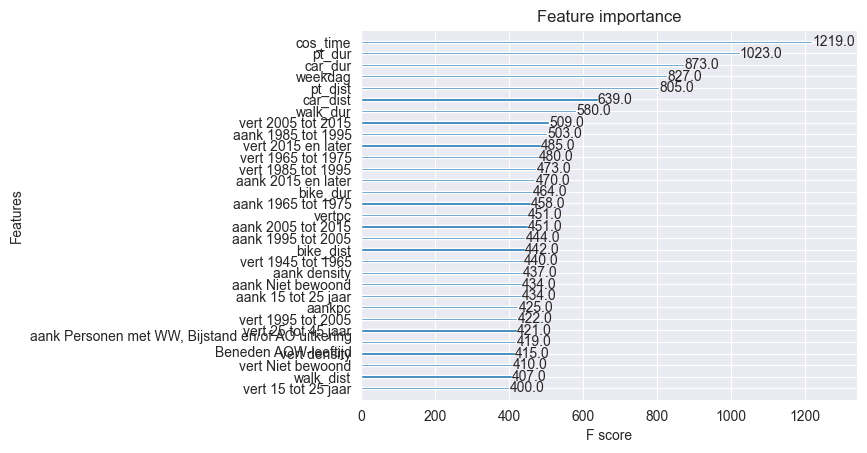

In [83]:
xgb.plot_importance(model, importance_type = 'weight', max_num_features = 31) # other options available


In [84]:
y_pred = le.inverse_transform(list(y_pred))
y_valid = le.inverse_transform(list(y_valid))
cm = confusion_matrix(y_valid, y_pred)
cl = list(le.inverse_transform(model.classes_))
dddf = pd.DataFrame(cm, columns=cl, index=cl)
# sns.heatmap(dddf, annot=True, fmt='.0f')
print(classification_report(list(y_valid), list(y_pred)))

                           precision    recall  f1-score   support

           Bus/tram/metro       0.44      0.21      0.28      1283
                    Fiets       0.57      0.59      0.58      8104
                   Overig       0.14      0.00      0.01      1125
Personenauto - bestuurder       0.64      0.87      0.74     12944
 Personenauto - passagier       0.56      0.26      0.35      4064
                  Te voet       0.40      0.15      0.22      1230
                    Trein       0.58      0.46      0.51      1250

                 accuracy                           0.60     30000
                macro avg       0.48      0.36      0.38     30000
             weighted avg       0.57      0.60      0.56     30000



In [85]:
fel_pred = model.predict_proba(X_test)

In [86]:
finaldf = pd.concat([test_data, pd.DataFrame(fel_pred, columns=le.inverse_transform(model.classes_)).round(2).set_index(test_data.index)], axis = 1)

In [87]:
finaldf['pred'] = le.inverse_transform(model.predict(X_test))
finaldf

,tripid,carId,fuelLevel,time,lat,lon,geometry,prev_time,timedelta,prev_location,...,"vert Personen met WW, Bijstand en/of AO uitkering\nBeneden AOW-leeftijd",vert density,Bus/tram/metro,Fiets,Overig,Personenauto - bestuurder,Personenauto - passagier,Te voet,Trein,pred
0,0,853,38,2023-01-02 18:50:40,52.358633,4.859237,POINT (4.85924 52.35863),2023-01-02 17:29:36,0 days 01:21:04,POINT (4.88286 52.37315),...,0.064323,0.978307,0.04,0.88,0.01,0.01,0.00,0.05,0.0,Fiets
1,104115,6412,22,2023-02-28 13:00:48,52.361151,4.873966,POINT (4.87397 52.36115),2023-02-28 12:09:36,0 days 00:51:12,POINT (4.88215 52.36602),...,0.064323,0.978307,0.00,0.66,0.01,0.01,0.00,0.32,0.0,Fiets
2,109658,6591,69,2023-02-05 02:08:00,52.359987,4.861473,POINT (4.86147 52.35999),2023-02-05 01:40:16,0 days 00:27:44,POINT (4.87676 52.37383),...,0.064323,0.978307,0.01,0.86,0.03,0.01,0.01,0.08,0.0,Fiets
3,117392,8147,89,2023-02-06 16:51:12,52.363555,4.875191,POINT (4.87519 52.36355),2023-02-06 16:36:16,0 days 00:14:56,POINT (4.88268 52.36742),...,0.064323,0.978307,0.00,0.70,0.01,0.01,0.00,0.27,0.0,Fiets
4,128180,1039,29,2023-03-25 02:22:06,52.361322,4.864722,POINT (4.86472 52.36132),2023-03-25 02:01:06,0 days 00:21:00,POINT (4.88230 52.36639),...,0.064323,0.978307,0.00,0.82,0.02,0.01,0.01,0.14,0.0,Fiets
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18460,11566,1227,19,2023-01-24 22:11:12,52.397060,4.939659,POINT (4.93966 52.39706),2023-01-24 21:58:24,0 days 00:12:48,POINT (4.92719 52.38636),...,0.077556,0.234520,0.03,0.71,0.01,0.17,0.02,0.06,0.0,Fiets
18461,127255,994,39,2023-03-26 07:17:06,52.399982,4.927011,POINT (4.92701 52.39998),2023-03-26 07:02:06,0 days 00:15:00,POINT (4.92742 52.38630),...,0.077556,0.234520,0.03,0.59,0.01,0.22,0.01,0.14,0.0,Fiets
18462,108676,6577,22,2023-02-09 18:42:08,52.404402,4.888060,POINT (4.88806 52.40440),2023-02-09 18:29:20,0 days 00:12:48,POINT (4.91479 52.39437),...,0.132342,0.256811,0.04,0.54,0.02,0.22,0.04,0.14,0.0,Fiets
18463,216456,2097,20,2023-04-17 09:44:32,52.346580,4.906011,POINT (4.90601 52.34658),2023-04-17 09:23:12,0 days 00:21:20,POINT (4.97355 52.32221),...,0.112496,0.309506,0.42,0.22,0.03,0.22,0.12,0.01,0.0,Bus/tram/metro


In [88]:
finaldf.pred.value_counts()

pred
Fiets                        16036
Te voet                       1058
Personenauto - bestuurder      828
Bus/tram/metro                 456
Overig                          40
Personenauto - passagier        30
Trein                           17
Name: count, dtype: int64

In [42]:
finaldf[list(le.inverse_transform(model.classes_))].sum()

Bus/tram/metro                1707.469849
Fiets                        12193.429688
Overig                         392.869965
Personenauto - bestuurder     1632.739990
Personenauto - passagier       258.250000
Te voet                       2213.560059
Trein                           28.930000
dtype: float32

In [89]:
import matplotlib.pyplot as plt

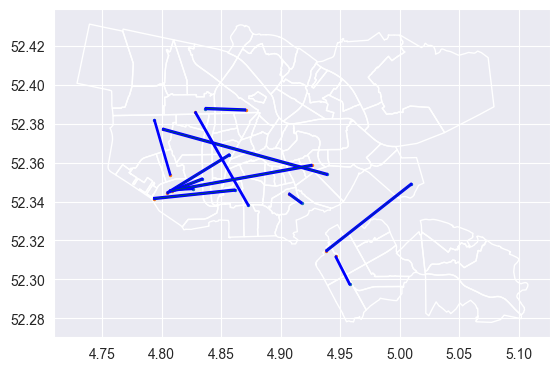

In [90]:
def plotjourneys(col, samples, finaldf = finaldf):
    best = finaldf[finaldf.pred == col]
    fig, ax = plt.subplots()
    PCs.plot(ax = ax, facecolor = 'None')

    trein = best.sample(samples)
    ax.scatter(trein.geometry.x, trein.geometry.y, s = 2)
    ax.scatter(trein.prev_location.x, trein.prev_location.y, s =2)

    for index, row in trein.iterrows():
        x = row['geometry'].x
        y = row['geometry'].y
        prev_x = row['prev_location'].x
        prev_y = row['prev_location'].y

        dx = x - prev_x
        dy = y - prev_y

        ax.arrow(prev_x, prev_y, dx, dy, head_width=0.0005, head_length=0.0005, fc='green', ec='blue')

plotjourneys('Personenauto - bestuurder', 12)

In [91]:
gr =finaldf.drop(['geometry', 'prev_location'], axis =1 ).groupby('pred').mean()
gr

TypeError: Could not convert ZondagDonderdagZondagMaandagDinsdagVrijdagDonderdagDonderdagMaandagMaandagDonderdagVrijdagDonderdagDonderdagVrijdagZondagMaandagMaandagWoensdagDonderdagDonderdagZondagDinsdagDinsdagVrijdagZaterdagZondagDonderdagZondagMaandagDonderdagMaandagDinsdagWoensdagWoensdagZondagZondagZaterdagDonderdagDinsdagZaterdagDonderdagVrijdagZondagVrijdagZondagDonderdagZondagDinsdagZondagVrijdagMaandagDonderdagVrijdagVrijdagZondagVrijdagWoensdagWoensdagDonderdagWoensdagWoensdagZondagZondagDonderdagMaandagZondagZaterdagVrijdagDinsdagMaandagDonderdagZaterdagZondagZaterdagZondagWoensdagDonderdagMaandagDinsdagDonderdagWoensdagMaandagDonderdagMaandagDonderdagWoensdagDinsdagWoensdagMaandagZondagZaterdagVrijdagDonderdagZondagZondagZaterdagDonderdagDonderdagZondagZondagMaandagDinsdagZaterdagWoensdagWoensdagZaterdagZondagVrijdagVrijdagDinsdagZondagZondagZondagWoensdagVrijdagDonderdagDonderdagWoensdagVrijdagMaandagDinsdagVrijdagZondagZondagMaandagDonderdagWoensdagZondagDinsdagZaterdagMaandagVrijdagVrijdagVrijdagVrijdagWoensdagMaandagVrijdagVrijdagZondagMaandagMaandagZondagMaandagVrijdagMaandagVrijdagDonderdagMaandagZondagMaandagVrijdagMaandagZaterdagWoensdagMaandagVrijdagDonderdagDinsdagMaandagVrijdagZondagMaandagZondagDinsdagWoensdagDinsdagZondagDinsdagWoensdagVrijdagZaterdagZaterdagVrijdagVrijdagDonderdagVrijdagZondagWoensdagVrijdagVrijdagMaandagDinsdagVrijdagZaterdagZondagVrijdagMaandagVrijdagZondagZondagWoensdagVrijdagZondagDinsdagZaterdagZondagDinsdagZaterdagWoensdagDonderdagZondagZaterdagDonderdagZaterdagZondagWoensdagDinsdagZondagMaandagDinsdagVrijdagMaandagDonderdagZondagVrijdagZaterdagVrijdagWoensdagZaterdagZaterdagZaterdagDonderdagZondagDonderdagVrijdagDonderdagDonderdagWoensdagZaterdagZaterdagVrijdagZondagVrijdagDonderdagZondagMaandagDonderdagDonderdagDinsdagDonderdagDinsdagZaterdagMaandagDinsdagWoensdagDonderdagZondagZondagMaandagZondagWoensdagVrijdagWoensdagWoensdagZondagDinsdagZondagDonderdagDinsdagDonderdagDonderdagZondagDinsdagZaterdagZondagZaterdagZondagDinsdagDinsdagVrijdagDonderdagDonderdagVrijdagWoensdagWoensdagMaandagZaterdagZaterdagWoensdagVrijdagZondagDinsdagWoensdagDonderdagZaterdagDinsdagZondagVrijdagMaandagWoensdagMaandagDonderdagZondagWoensdagMaandagMaandagVrijdagVrijdagMaandagZondagWoensdagZaterdagDinsdagVrijdagWoensdagZaterdagZondagZondagWoensdagZondagZaterdagVrijdagZaterdagVrijdagWoensdagZaterdagWoensdagDinsdagVrijdagMaandagZondagDonderdagZondagDonderdagWoensdagZondagMaandagZondagMaandagDonderdagZondagDinsdagMaandagDinsdagZondagZondagZondagDonderdagDonderdagVrijdagVrijdagDonderdagZondagZondagDinsdagDinsdagVrijdagDinsdagZaterdagZondagDonderdagDinsdagZondagWoensdagZondagZondagZaterdagZondagMaandagDonderdagVrijdagMaandagDonderdagDonderdagVrijdagVrijdagZondagDonderdagDinsdagMaandagMaandagDinsdagWoensdagVrijdagZaterdagMaandagVrijdagWoensdagDinsdagMaandagMaandagZaterdagVrijdagDinsdagVrijdagVrijdagZaterdagZaterdagZaterdagZondagDonderdagVrijdagZondagDonderdagZaterdagDonderdagWoensdagMaandagVrijdagDinsdagZaterdagDonderdagDonderdagZondagVrijdagVrijdagDonderdagZaterdagDinsdagWoensdagMaandagVrijdagZondagVrijdagDinsdagVrijdagVrijdagDinsdagZaterdagDinsdagVrijdagMaandagMaandagDinsdagVrijdagWoensdagZondagDinsdagDonderdagVrijdagZondagZondagZondagDinsdagDonderdagVrijdagDonderdagVrijdagDonderdagMaandagVrijdagVrijdagVrijdagWoensdagMaandagDonderdagZaterdagVrijdagDonderdagWoensdagVrijdagMaandagMaandagVrijdag to numeric

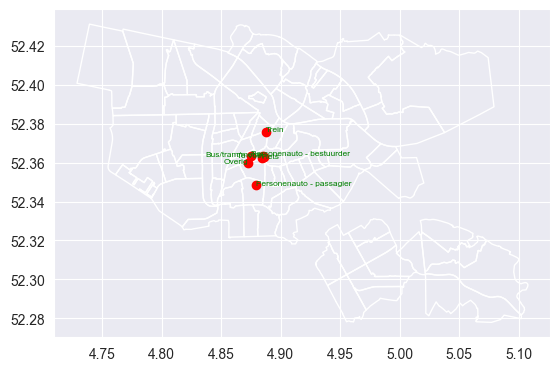

In [50]:
fig, ax = plt.subplots()
PCs.plot(ax=ax, facecolor='None')
# trein.plot(ax = ax)
ax.scatter(gr.lon, gr.lat, color='red')
has = ['right', 'left', 'right', 'left', 'left', 'right', 'left']
for i, txt in enumerate(gr.index):
    ax.annotate(txt, (gr.lon[i], gr.lat[i]), color='green', fontsize = 6, horizontalalignment = has[i])
# ax.scatter(gr.prev_lat, gr.prev_lon, color='blue')